做阅读理解任务之前，需要了解以下几点：
1. 阅读理解任务的目标是找到答案的"start_positions"和"end_positions"，这个position是token的position而不是答案在原文字符串中的offset
2. 标注数据中给出的是答案在原文字符串中的offset，需要计算得到标准的"start_positions"和"end_positions"
3. 在阅读理解中的分词结果中，[cls] question tokens [sep] context tokens [pad] [sep]
4. 还有个问题待定，question和context的长度如果太长，会如何处理？

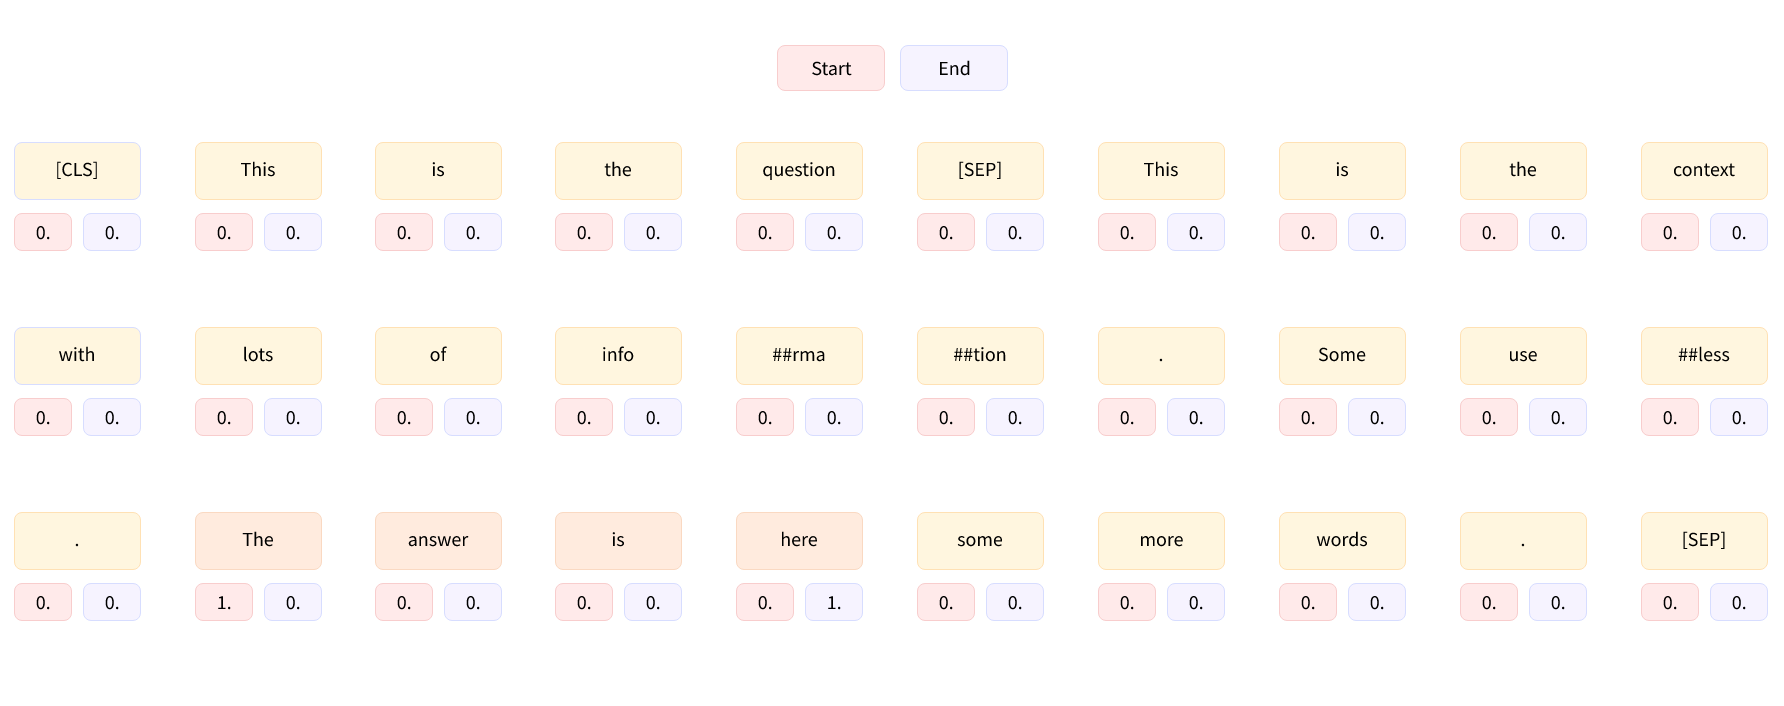

In [1]:
from functools import partial
import numpy as np
import paddle
import pandas as pd
from paddle.utils import run_check
from paddle import nn
import paddlenlp
import paddle.nn.functional as F
from paddlenlp.data import Stack, Tuple, Pad, Dict
from paddlenlp.datasets import load_dataset
from paddlenlp import datasets, transformers
from visualdl import LogWriter

run_check()
print('自然语言相关数据集：', paddle.text.__all__)

C:\Users\guor\.conda\envs\qq\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\guor\.conda\envs\qq\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Running verify PaddlePaddle program ... 
PaddlePaddle works well on 1 GPU.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.
自然语言相关数据集： ['Conll05st', 'Imdb', 'Imikolov', 'Movielens', 'UCIHousing', 'WMT14', 'WMT16', 'ViterbiDecoder', 'viterbi_decode']


In [2]:
train_ds, dev_ds = paddlenlp.datasets.load_dataset('cmrc2018',splits=['train','dev'])

In [3]:
MODEL_NAME = "ernie-3.0-medium-zh"
#ernie_model = paddlenlp.transformers.ErnieModel.from_pretrained(MODEL_NAME)
model = paddlenlp.transformers.AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
tokenizer = paddlenlp.transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

[2023-07-29 16:37:30,928] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForQuestionAnswering'> to load 'ernie-3.0-medium-zh'.
[2023-07-29 16:37:30,931] [    INFO] - Model config ErnieConfig {
  "attention_probs_dropout_prob": 0.1,
  "enable_recompute": false,
  "fuse": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "model_type": "ernie",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "paddlenlp_version": null,
  "pool_act": "tanh",
  "task_id": 0,
  "task_type_vocab_size": 16,
  "type_vocab_size": 4,
  "use_task_id": true,
  "vocab_size": 40000
}

[2023-07-29 16:37:32,814] [ WARNING] - Some weights of the model checkpoint at ernie-3.0-medium-zh were not used when initializing ErnieForQuestionAnswering: ['ernie.encoder.layers.6.self_attn.v_proj.bias', 'ernie.encoder.laye

In [4]:
example=train_ds[0]
print(example)

{'id': 'TRAIN_186_QUERY_0', 'title': '范廷颂', 'context': '范廷颂枢机（，），圣名保禄·若瑟（），是越南罗马天主教枢机。1963年被任为主教；1990年被擢升为天主教河内总教区宗座署理；1994年被擢升为总主教，同年年底被擢升为枢机；2009年2月离世。范廷颂于1919年6月15日在越南宁平省天主教发艳教区出生；童年时接受良好教育后，被一位越南神父带到河内继续其学业。范廷颂于1940年在河内大修道院完成神学学业。范廷颂于1949年6月6日在河内的主教座堂晋铎；及后被派到圣女小德兰孤儿院服务。1950年代，范廷颂在河内堂区创建移民接待中心以收容到河内避战的难民。1954年，法越战争结束，越南民主共和国建都河内，当时很多天主教神职人员逃至越南的南方，但范廷颂仍然留在河内。翌年管理圣若望小修院；惟在1960年因捍卫修院的自由、自治及拒绝政府在修院设政治课的要求而被捕。1963年4月5日，教宗任命范廷颂为天主教北宁教区主教，同年8月15日就任；其牧铭为「我信天主的爱」。由于范廷颂被越南政府软禁差不多30年，因此他无法到所属堂区进行牧灵工作而专注研读等工作。范廷颂除了面对战争、贫困、被当局迫害天主教会等问题外，也秘密恢复修院、创建女修会团体等。1990年，教宗若望保禄二世在同年6月18日擢升范廷颂为天主教河内总教区宗座署理以填补该教区总主教的空缺。1994年3月23日，范廷颂被教宗若望保禄二世擢升为天主教河内总教区总主教并兼天主教谅山教区宗座署理；同年11月26日，若望保禄二世擢升范廷颂为枢机。范廷颂在1995年至2001年期间出任天主教越南主教团主席。2003年4月26日，教宗若望保禄二世任命天主教谅山教区兼天主教高平教区吴光杰主教为天主教河内总教区署理主教；及至2005年2月19日，范廷颂因获批辞去总主教职务而荣休；吴光杰同日真除天主教河内总教区总主教职务。范廷颂于2009年2月22日清晨在河内离世，享年89岁；其葬礼于同月26日上午在天主教河内总教区总主教座堂举行。', 'question': '范廷颂是什么时候被任为主教的？', 'answers': ['1963年'], 'answer_starts': [30]}


In [5]:
def preprocess_function(example, tokenizer):
    tokenized_example = tokenizer(
        example['question'],
        example["context"],
        truncation="only_second",
        return_offsets_mapping=True,
        return_overflowing_tokens=True
    )
    # We will label impossible answers with the index of the CLS token.
    input_ids = tokenized_example["input_ids"]
    cls_index = input_ids.index(tokenizer.cls_token_id)
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offsets = tokenized_example['offset_mapping']
    # Grab the sequence corresponding to that example (to know what is the context and what is the question).
    sequence_ids = tokenized_example['token_type_ids']

    answers = example['answers']
    answer_starts = example['answer_starts']

    # Start/end character index of the answer in the text.
    start_char = answer_starts[0]
    end_char = start_char + len(answers[0])

    # Start token index of the current span in the text.
    token_start_index = 0
    while sequence_ids[token_start_index] != 1:
        token_start_index += 1

    # End token index of the current span in the text.
    token_end_index = len(input_ids) - 1
    while sequence_ids[token_end_index] != 1:
        token_end_index -= 1
    # Minus one more to reach actual text
    token_end_index -= 1

    # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
    if not (offsets[token_start_index][0] <= start_char and
            offsets[token_end_index][1] >= end_char):
        tokenized_example["start_positions"] = cls_index
        tokenized_example["end_positions"] = cls_index
    else:
        # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
        # Note: we could go after the last offset if the answer is the last word (edge case).
        while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
            token_start_index += 1
        tokenized_example["start_positions"] = token_start_index - 1
        while offsets[token_end_index][1] >= end_char:
            token_end_index -= 1
        tokenized_example["end_positions"] = token_end_index + 1

    return tokenized_example['input_ids'], tokenized_example['token_type_ids'], tokenized_example['start_positions'], tokenized_example['end_positions']

In [6]:
# 数据处理，从文本到处理好的数据，input_ids，token_type_ids
def create_train_dataloader(dataset, tokenizer, batch_size):
    batchify_fn = lambda samples, fn=Tuple([
        Pad(axis=0, pad_val=tokenizer.pad_token_id),
        Pad(axis=0, pad_val=tokenizer.pad_token_type_id),
        Stack(dtype="int64"),
        Stack(dtype="int64")
    ]): fn(samples)
    batch_sampler = paddle.io.DistributedBatchSampler(dataset, batch_size=batch_size, shuffle=True)
    return paddle.io.DataLoader(dataset=dataset, batch_sampler=batch_sampler, collate_fn=batchify_fn, return_list=True)
    

trans_func = partial(preprocess_function, tokenizer=tokenizer)
train_ds.map(trans_func)
train_data_loader = create_train_dataloader(dataset=train_ds, tokenizer=tokenizer, batch_size=2)

In [ ]:
class CrossEntropyLossForSQuAD(paddle.nn.Layer):
    def __init__(self):
        super(CrossEntropyLossForSQuAD, self).__init__()

    def forward(self, y, label):
        start_logits, end_logits = y   # both shape are [batch_size, seq_len]
        start_position, end_position = label
        start_position = paddle.unsqueeze(start_position, axis=-1)
        end_position = paddle.unsqueeze(end_position, axis=-1)
        start_loss = paddle.nn.functional.softmax_with_cross_entropy(
            logits=start_logits, label=start_position, soft_label=False)
        start_loss = paddle.mean(start_loss)
        end_loss = paddle.nn.functional.softmax_with_cross_entropy(
            logits=end_logits, label=end_position, soft_label=False)
        end_loss = paddle.mean(end_loss)

        loss = (start_loss + end_loss) / 2
        return loss

In [ ]:
# 定义 optimizer 优化器
optimizer = paddle.optimizer.AdamW(learning_rate=3e-5, parameters=model.parameters())
# 定义 loss
criterion = CrossEntropyLossForSQuAD()
# 训练
epochs = 1
global_step = 0
with LogWriter(logdir="./logs") as writer:
    for epoch in range(1, epochs + 1):
        for step, batch in enumerate(train_data_loader, start=1):
            input_ids, token_type_ids, start_positions, end_positions = batch
            logits = model(input_ids=input_ids, token_type_ids=token_type_ids)
            loss = criterion(logits, (start_positions, end_positions))

            # 向记录器添加一个tag为`loss`的数据
            writer.add_scalar(tag="loss", step=global_step, value=loss)
            global_step += 1
            if global_step % 10 == 0:
                print("epoch %d, step %d: loss:%.5f" % (epoch, step, loss))
            loss.backward()
            optimizer.step()
            optimizer.clear_grad()

In [ ]:
# TODO 基于模型计算的start_positions, end_positions，反向推导答案